## Notebook used for constructing the datasets used in the empirical section

### 1) historical Standard & Poors 500 constituents dataset fetched from eodhd.com

In [175]:
import pickle
import os 

with open("eod_key.pkl", "rb") as input_file:
  eod_key = pickle.load(input_file)

from urllib.request import urlopen
import pandas as pd
import numpy as np
import urllib.request
from urllib.error import HTTPError

# Function to get the Data

def get_jsonparsed_data(url):
    res = urlopen(url)
    data = res.read().decode("utf-8")
    return json.loads(data)

def find_when_active(cons,tick):
    '''
    oututs a list of tuples containing the datetimes of when it first started and ended being part of the s&p500
    '''
    mask = cons['tickers'].apply(lambda x: tick in x)
    part_of = []
    active = False
    for idx in range(len(cons)):
        # first time appearing 
        if not active and mask.iloc[idx]:
            start    = mask.index[idx]
            active = True
            continue
        # removed from index
        if active and not mask.iloc[idx]:
            end      = mask.index[idx]
            active   = False
            part_of.append((start,end))
            continue

    if active:
        end = mask.index[-1]
        part_of.append((start,end))
    assert len(part_of) != 0
    return part_of

import datetime as dt
from tqdm import tqdm 

filename = 'price_df.csv'

# first look up the historical s&p 500 constituents
constituents = pd.read_csv('sp500.csv')
constituents.date  = pd.to_datetime(constituents.date)
constituents.set_index(constituents.date, inplace=True)
constituents.drop(columns=['date'],inplace=True)

constituents['tickers'] = constituents['tickers'].apply(lambda row: row.split(','))
all_tickers = set(np.concatenate(constituents.tickers.values))

begin = constituents.index[0]
end   = constituents.index[-1]

price_df = pd.DataFrame(index=pd.date_range(start=begin, end=end, freq="B"), columns = list(all_tickers))
failed_to_add = list()

# check if the file already exists
# if os.path.exists(filename):
#     price_df = pd.read_csv(filename)
#     price_df = price_df.rename(columns={'Unnamed: 0':'date'})
#     price_df.set_index('date', inplace=True)    

for count, ticker in enumerate(tqdm(all_tickers)):
    # find the correct dates the stock was part of the s&p 500
    for start, stop in find_when_active(constituents, ticker):
        # fetch data using eod api
        try:
            df  = get_jsonparsed_data("https://eodhd.com/api/eod/{}.US?from={}&to={}&period=d&api_token={}&fmt=json".format(ticker.replace('.','-'),
                start.strftime('%Y-%m-%d'),stop.strftime('%Y-%m-%d'), eod_key))
        except HTTPError as e:
            if e.code == 404:
                print('404 not found from api for ticker: {}'.format(ticker))
                failed_to_add.append(ticker)
                continue
            else:
                print(e)
        # output if no data was able to be found
        if len(df) == 0:
            print('No data found for {} from {} until {}'.format(ticker,start.strftime('%Y-%m-%d'),stop.strftime('%Y-%m-%d')),end="")
            failed_to_add.append(ticker)
            continue
        df1 = pd.DataFrame(df)
        df1['date'] = pd.to_datetime(df1['date'])
        df1.set_index('date',inplace=True)
        # merge the dataset
        price_df.loc[df1.index, ticker] = df1['adjusted_close']    

    #occasionally backup the dataframe
    if count % 20 == 0:
        price_df.to_csv(filename)

price_df.to_csv(filename) #save when done

  1%|          | 6/1156 [00:24<51:10,  2.67s/it]  

No data found for PZE from 1996-01-02 until 1998-12-31

  1%|          | 14/1156 [00:42<43:06,  2.27s/it]

No data found for DOW from 1996-01-02 until 2017-09-01

  2%|▏         | 23/1156 [01:11<1:06:07,  3.50s/it]

No data found for BR from 1996-01-02 until 2006-04-03

  3%|▎         | 31/1156 [01:49<1:04:38,  3.45s/it]

No data found for LOR from 1996-01-02 until 1996-04-23

  3%|▎         | 34/1156 [01:55<43:22,  2.32s/it]  

No data found for ALTR from 2000-04-18 until 2015-12-28

  4%|▍         | 45/1156 [02:54<44:27,  2.40s/it]  

No data found for MDR from 1996-01-02 until 2003-08-20

  4%|▍         | 52/1156 [03:31<2:32:17,  8.28s/it]

No data found for NE from 2001-01-16 until 2009-03-27

  5%|▍         | 53/1156 [03:33<1:57:05,  6.37s/it]

No data found for NE from 2011-01-18 until 2015-07-20

  5%|▌         | 60/1156 [04:23<2:13:49,  7.33s/it]

No data found for DI from 1996-01-02 until 1998-09-30

  6%|▌         | 64/1156 [04:35<1:04:45,  3.56s/it]

No data found for COV from 1996-01-02 until 1996-08-16

  7%|▋         | 85/1156 [06:57<2:49:50,  9.51s/it]

No data found for PVT from 1998-08-31 until 1999-07-01

  7%|▋         | 86/1156 [06:58<2:03:42,  6.94s/it]

No data found for HCR from 1998-09-28 until 2007-11-09

  8%|▊         | 88/1156 [07:01<1:11:26,  4.01s/it]

No data found for EC from 1996-01-02 until 2006-06-06

  8%|▊         | 94/1156 [07:16<51:36,  2.92s/it]  

No data found for TMC from 1996-01-02 until 2000-06-13

 10%|▉         | 115/1156 [08:07<38:33,  2.22s/it]

No data found for CHK from 2006-03-03 until 2018-03-19

 10%|█         | 116/1156 [08:27<2:10:28,  7.53s/it]

No data found for SE from 2007-01-03 until 2017-02-27

 10%|█         | 119/1156 [08:52<2:44:45,  9.53s/it]

No data found for CCB from 1996-01-02 until 1996-02-12

 11%|█         | 124/1156 [09:05<59:36,  3.47s/it]  

No data found for GSX from 1996-01-02 until 1998-10-07

 11%|█         | 125/1156 [09:06<46:21,  2.70s/it]

No data found for FRO from 1997-01-02 until 1999-09-29

 12%|█▏        | 133/1156 [09:26<37:02,  2.17s/it]

404 not found from api for ticker: PEL


 12%|█▏        | 137/1156 [09:32<29:00,  1.71s/it]

No data found for GP from 1996-01-02 until 2005-12-20

 12%|█▏        | 144/1156 [09:54<41:28,  2.46s/it]  

404 not found from api for ticker: GIDL


 13%|█▎        | 147/1156 [10:02<41:50,  2.49s/it]

No data found for HCA from 1996-01-02 until 2006-11-20

 15%|█▍        | 172/1156 [11:17<37:23,  2.28s/it]  

404 not found from api for ticker: MST
No data found for MIR from 1997-08-07 until 2000-06-01

 15%|█▍        | 173/1156 [11:19<35:40,  2.18s/it]

No data found for MIR from 2001-04-03 until 2003-07-17

 15%|█▌        | 176/1156 [11:24<27:03,  1.66s/it]

No data found for HMA from 2001-11-07 until 2007-03-02

 16%|█▌        | 185/1156 [12:05<2:05:10,  7.73s/it]

No data found for PSFT from 1998-10-02 until 2004-12-29

 16%|█▋        | 189/1156 [12:15<57:53,  3.59s/it]  

No data found for MMI from 2011-01-04 until 2012-05-22

 19%|█▊        | 216/1156 [13:57<34:40,  2.21s/it]  

No data found for MYG from 1996-01-02 until 2006-04-03

 19%|█▉        | 219/1156 [14:04<32:55,  2.11s/it]

No data found for AT from 1996-01-02 until 2007-11-19

 20%|█▉        | 228/1156 [15:06<1:06:24,  4.29s/it]

No data found for CNW from 1996-01-02 until 1996-12-03

 20%|█▉        | 229/1156 [15:07<50:57,  3.30s/it]  

No data found for S from 1996-01-02 until 2013-07-09

 20%|██        | 232/1156 [15:15<42:49,  2.78s/it]

No data found for ASND from 1998-06-12 until 1999-06-25No data found for KMI from 2000-12-12 until 2007-05-31

 21%|██        | 237/1156 [16:02<1:10:15,  4.59s/it]

No data found for HCP from 2008-03-31 until 2019-11-05

 22%|██▏       | 257/1156 [17:06<24:51,  1.66s/it]  

No data found for AMH from 1996-01-02 until 1997-09-15

 22%|██▏       | 258/1156 [17:07<21:51,  1.46s/it]

No data found for PLL from 1996-01-02 until 2015-08-31

 23%|██▎       | 262/1156 [17:18<32:24,  2.17s/it]

No data found for JP from 1996-01-02 until 2006-04-03

 24%|██▍       | 276/1156 [17:54<30:00,  2.05s/it]

No data found for AV from 2000-10-02 until 2007-10-26

 24%|██▍       | 279/1156 [18:02<31:32,  2.16s/it]

No data found for CG from 1996-01-02 until 2000-11-02

 25%|██▍       | 285/1156 [18:15<26:08,  1.80s/it]

No data found for BEAM from 1996-01-02 until 2014-05-01

 26%|██▌       | 300/1156 [19:51<1:24:00,  5.89s/it]

No data found for BHMSQ from 1996-01-02 until 2000-12-11

 28%|██▊       | 320/1156 [22:12<2:11:20,  9.43s/it]

No data found for SB from 1996-01-02 until 1997-11-28

 28%|██▊       | 322/1156 [22:18<1:22:17,  5.92s/it]

No data found for FMY from 1998-07-10 until 1999-05-28

 29%|██▉       | 334/1156 [22:45<24:07,  1.76s/it]  

No data found for THY from 1996-01-02 until 1996-10-16

 29%|██▉       | 335/1156 [22:46<20:56,  1.53s/it]

No data found for CFL from 1996-01-02 until 1998-04-28

 29%|██▉       | 337/1156 [22:52<27:33,  2.02s/it]

No data found for PGN from 1996-01-02 until 2012-07-02

 30%|███       | 352/1156 [24:01<24:32,  1.83s/it]  

No data found for ENS from 1996-01-02 until 1997-08-06

 31%|███       | 355/1156 [24:09<28:42,  2.15s/it]

No data found for EQ from 2006-05-18 until 2009-07-01

 31%|███       | 357/1156 [24:12<21:42,  1.63s/it]

No data found for NLC from 1996-01-02 until 1999-08-02

 32%|███▏      | 372/1156 [24:47<21:26,  1.64s/it]

404 not found from api for ticker: NMK


 33%|███▎      | 379/1156 [25:07<36:26,  2.81s/it]

No data found for CE from 2001-04-02 until 2004-02-27

 34%|███▎      | 389/1156 [25:53<1:41:26,  7.94s/it]

No data found for ADCT from 1999-08-02 until 2007-07-02

 34%|███▍      | 393/1156 [26:00<40:11,  3.16s/it]  

No data found for RDS.A from 1996-01-02 until 2002-07-22

 34%|███▍      | 394/1156 [26:01<31:36,  2.49s/it]

No data found for CRR from 1996-01-02 until 1997-05-27

 34%|███▍      | 395/1156 [26:02<25:45,  2.03s/it]

No data found for RYI from 1996-01-02 until 1998-07-01

 35%|███▍      | 400/1156 [26:17<31:50,  2.53s/it]

No data found for TRW from 1996-01-02 until 2002-12-12

 36%|███▌      | 414/1156 [27:21<34:16,  2.77s/it]  

No data found for NSM from 1996-01-02 until 2011-09-26

 36%|███▋      | 420/1156 [27:33<23:20,  1.90s/it]

No data found for MNR from 1996-01-02 until 1998-09-28

 37%|███▋      | 432/1156 [28:25<31:18,  2.60s/it]  

404 not found from api for ticker: TDM


 37%|███▋      | 433/1156 [28:26<25:06,  2.08s/it]

No data found for LLL from 2004-12-01 until 2019-07-01

 38%|███▊      | 435/1156 [28:29<21:48,  1.81s/it]

No data found for AAMRQ from 1996-01-02 until 2003-03-14

 38%|███▊      | 438/1156 [28:36<23:31,  1.97s/it]

No data found for COMS from 1996-01-02 until 2000-07-28

 38%|███▊      | 443/1156 [28:47<25:24,  2.14s/it]

No data found for SRR from 1996-01-02 until 1997-10-07

 39%|███▉      | 448/1156 [28:59<28:52,  2.45s/it]

No data found for CF from 2000-06-19 until 2004-09-01

 39%|███▉      | 450/1156 [29:04<26:05,  2.22s/it]

No data found for CBH from 2006-06-06 until 2008-03-31

 40%|████      | 463/1156 [30:12<38:06,  3.30s/it]  

No data found for MEDI from 2000-06-16 until 2007-06-01

 40%|████      | 465/1156 [30:14<25:53,  2.25s/it]

No data found for TA from 1996-01-02 until 1999-07-22

 41%|████      | 471/1156 [30:25<18:57,  1.66s/it]

404 not found from api for ticker: BLY


 41%|████      | 472/1156 [30:26<16:21,  1.43s/it]

No data found for ASO from 1999-03-10 until 2006-11-06

 41%|████      | 474/1156 [30:30<18:51,  1.66s/it]

No data found for DELL from 1996-09-06 until 2013-10-29

 41%|████▏     | 478/1156 [30:42<29:42,  2.63s/it]

No data found for AAL from 1996-01-02 until 1997-01-15

 42%|████▏     | 480/1156 [31:08<1:39:47,  8.86s/it]

No data found for MTLQQ from 1996-01-02 until 2009-06-03

 42%|████▏     | 488/1156 [31:30<32:48,  2.95s/it]  

No data found for DEC from 1996-01-02 until 1998-06-12

 42%|████▏     | 491/1156 [31:35<21:48,  1.97s/it]

No data found for HI from 1996-01-02 until 2003-03-31

 43%|████▎     | 493/1156 [31:37<16:31,  1.50s/it]

No data found for LIFE from 2008-11-24 until 2014-01-24

 43%|████▎     | 495/1156 [31:40<16:19,  1.48s/it]

No data found for RE from 2017-06-19 until 2023-06-10

 44%|████▎     | 503/1156 [32:01<24:39,  2.27s/it]

No data found for SDS from 2002-07-22 until 2005-08-12

 44%|████▍     | 512/1156 [32:24<21:31,  2.00s/it]

No data found for MNK from 2014-08-19 until 2017-07-26

 44%|████▍     | 514/1156 [32:27<17:57,  1.68s/it]

No data found for RYAN from 1996-01-02 until 1997-01-02

 45%|████▍     | 517/1156 [32:34<20:26,  1.92s/it]

No data found for ASC from 1996-01-02 until 1999-06-24

 45%|████▍     | 520/1156 [32:43<24:35,  2.32s/it]

No data found for SAI from 1997-07-17 until 1999-01-04

 46%|████▌     | 529/1156 [33:09<22:27,  2.15s/it]

No data found for IR from 1996-01-02 until 2009-07-01

 46%|████▌     | 533/1156 [34:14<1:39:00,  9.54s/it]

No data found for DYN from 2000-10-03 until 2009-12-21

 47%|████▋     | 548/1156 [34:48<20:45,  2.05s/it]  

No data found for CNXT from 2000-01-31 until 2002-06-26

 47%|████▋     | 549/1156 [34:49<17:12,  1.70s/it]

No data found for STR from 2006-12-01 until 2010-07-01

 48%|████▊     | 553/1156 [35:01<24:36,  2.45s/it]

No data found for NLV from 1996-04-01 until 2000-01-06

 48%|████▊     | 554/1156 [35:02<20:05,  2.00s/it]

No data found for WLP from 1999-06-09 until 2004-12-01

 48%|████▊     | 559/1156 [35:12<18:43,  1.88s/it]

No data found for SMI from 1996-01-02 until 2000-12-12

 48%|████▊     | 560/1156 [35:13<15:51,  1.60s/it]

No data found for GTE from 1996-01-02 until 2000-07-03

 49%|████▉     | 569/1156 [35:32<13:56,  1.42s/it]

404 not found from api for ticker: NAE


 49%|████▉     | 570/1156 [36:08<1:54:59, 11.77s/it]

No data found for AM from 1996-01-02 until 2004-05-03

 49%|████▉     | 572/1156 [36:12<1:05:13,  6.70s/it]

No data found for PMI from 1996-01-02 until 1996-05-31

 50%|████▉     | 573/1156 [36:13<48:41,  5.01s/it]  

No data found for ECO from 1996-01-02 until 1998-01-20

 51%|█████     | 591/1156 [38:12<48:07,  5.11s/it]  

No data found for HLT from 1996-01-02 until 2007-10-25

 52%|█████▏    | 597/1156 [38:28<26:00,  2.79s/it]

No data found for AGC from 1996-01-02 until 2001-08-29

 52%|█████▏    | 599/1156 [38:32<21:48,  2.35s/it]

No data found for JAVA from 1996-01-02 until 2010-01-27

 52%|█████▏    | 600/1156 [38:33<17:56,  1.94s/it]

No data found for WCOEQ from 1996-04-01 until 2002-05-15404 not found from api for ticker: HFS


 53%|█████▎    | 610/1156 [39:34<59:09,  6.50s/it]  

No data found for SK from 1996-01-02 until 1998-04-01

 53%|█████▎    | 618/1156 [39:49<19:20,  2.16s/it]

No data found for UPC from 1998-10-01 until 2004-07-01

 54%|█████▎    | 619/1156 [39:50<16:01,  1.79s/it]

No data found for PCS from 1998-11-24 until 2004-04-23

 54%|█████▍    | 626/1156 [40:08<21:08,  2.39s/it]

No data found for CDAY from 2021-09-20 until 2023-10-18

 55%|█████▍    | 632/1156 [40:24<20:13,  2.32s/it]

No data found for MIL from 1996-01-02 until 2010-07-15

 55%|█████▍    | 635/1156 [40:33<21:53,  2.52s/it]

No data found for VAT from 1996-01-02 until 1996-09-06

 56%|█████▌    | 648/1156 [41:26<22:14,  2.63s/it]  

No data found for ABI from 1996-01-02 until 2008-11-24

 56%|█████▌    | 649/1156 [41:26<17:52,  2.12s/it]

No data found for ABKFQ from 2000-12-11 until 2008-06-11

 56%|█████▋    | 653/1156 [41:36<18:10,  2.17s/it]

No data found for RSHCQ from 1996-01-02 until 2011-07-01

 57%|█████▋    | 655/1156 [41:39<15:02,  1.80s/it]

No data found for INGR from 1996-01-02 until 1997-07-28

 57%|█████▋    | 660/1156 [41:50<17:45,  2.15s/it]

No data found for JH from 1996-01-02 until 1998-04-01

 58%|█████▊    | 665/1156 [42:03<18:07,  2.21s/it]

No data found for Q from 2000-07-06 until 2011-04-01

 58%|█████▊    | 670/1156 [42:14<18:03,  2.23s/it]

No data found for UK from 1996-01-02 until 2001-02-07

 58%|█████▊    | 672/1156 [42:18<16:09,  2.00s/it]

No data found for I from 1996-01-02 until 1996-04-01

 59%|█████▊    | 677/1156 [42:25<11:04,  1.39s/it]

No data found for BOAT from 1996-01-02 until 1997-01-07

 59%|█████▊    | 679/1156 [42:29<12:59,  1.63s/it]

No data found for ADT from 2012-10-02 until 2016-05-02

 59%|█████▉    | 680/1156 [42:30<11:17,  1.42s/it]

No data found for LDW.B from 1996-01-02 until 1999-12-08

 59%|█████▉    | 682/1156 [42:37<17:20,  2.19s/it]

No data found for BNL from 1996-01-02 until 1998-07-01

 60%|█████▉    | 689/1156 [43:04<21:32,  2.77s/it]

No data found for EFU from 1996-01-02 until 2000-11-02

 60%|█████▉    | 692/1156 [43:10<16:06,  2.08s/it]

404 not found from api for ticker: USHC


 60%|██████    | 695/1156 [43:16<14:33,  1.90s/it]

No data found for GRN from 1996-01-02 until 1998-12-22

 60%|██████    | 696/1156 [43:17<12:22,  1.61s/it]

No data found for CA from 1996-01-02 until 2018-11-06

 61%|██████    | 700/1156 [43:46<33:55,  4.46s/it]

No data found for BEV from 1996-01-02 until 1997-12-04

 61%|██████    | 702/1156 [43:51<25:16,  3.34s/it]

No data found for MON from 2002-08-14 until 2018-06-07

 61%|██████    | 707/1156 [43:59<12:52,  1.72s/it]

No data found for UAWGQ from 1996-01-02 until 2002-05-15

 61%|██████▏   | 710/1156 [44:05<12:23,  1.67s/it]

404 not found from api for ticker: FBO


 62%|██████▏   | 715/1156 [44:13<10:59,  1.50s/it]

No data found for MEA from 1996-01-02 until 2002-01-30

 62%|██████▏   | 716/1156 [44:14<09:41,  1.32s/it]

No data found for AR from 1996-01-02 until 1999-10-27

 62%|██████▏   | 720/1156 [44:24<13:26,  1.85s/it]

No data found for ARC from 1996-01-02 until 2000-04-18

 63%|██████▎   | 725/1156 [44:41<18:47,  2.61s/it]

No data found for USBC from 1996-01-02 until 1997-08-04

 63%|██████▎   | 729/1156 [44:49<13:24,  1.88s/it]

No data found for CEN from 1996-01-02 until 2001-04-02

 64%|██████▎   | 736/1156 [45:39<39:35,  5.66s/it]  

No data found for PHB from 1996-01-02 until 1999-10-04

 64%|██████▍   | 738/1156 [45:42<23:55,  3.43s/it]

No data found for ECH from 1996-01-02 until 1998-07-10

 64%|██████▍   | 743/1156 [45:57<18:57,  2.75s/it]

No data found for LU from 1996-10-01 until 2006-12-01

 65%|██████▍   | 746/1156 [46:04<15:33,  2.28s/it]

No data found for UCL from 1996-01-02 until 2005-08-11

 65%|██████▍   | 750/1156 [46:17<17:46,  2.63s/it]

No data found for GFS.A from 1996-01-02 until 1998-07-16

 65%|██████▍   | 751/1156 [46:18<14:47,  2.19s/it]

No data found for UCC from 1996-01-02 until 1999-05-03

 65%|██████▌   | 756/1156 [46:29<14:01,  2.10s/it]

No data found for CEG from 1996-01-02 until 2012-03-13

 66%|██████▌   | 759/1156 [46:35<12:25,  1.88s/it]

No data found for TMC.A from 1996-01-02 until 2000-06-13

 66%|██████▌   | 762/1156 [46:48<22:51,  3.48s/it]

No data found for UMG from 1996-01-02 until 2000-06-15

 66%|██████▋   | 766/1156 [47:04<19:44,  3.04s/it]

No data found for VRTS from 2000-04-03 until 2005-07-05

 67%|██████▋   | 770/1156 [47:13<14:31,  2.26s/it]

No data found for RLM from 1996-01-02 until 2000-05-04

 68%|██████▊   | 786/1156 [48:19<19:57,  3.24s/it]

404 not found from api for ticker: DWD


 69%|██████▊   | 794/1156 [49:13<1:16:04, 12.61s/it]

No data found for PD from 1996-01-02 until 2007-03-20

 69%|██████▉   | 802/1156 [49:39<21:15,  3.60s/it]  

No data found for WLL from 1996-01-02 until 2002-02-11

 70%|███████   | 811/1156 [49:58<10:28,  1.82s/it]

No data found for ANV from 1996-01-02 until 1999-04-12

 71%|███████   | 820/1156 [50:35<44:03,  7.87s/it]

No data found for PBY from 1996-01-02 until 2000-04-03

 73%|███████▎  | 839/1156 [51:18<08:58,  1.70s/it]

No data found for SFS from 1996-01-02 until 1997-07-28

 73%|███████▎  | 847/1156 [51:44<12:32,  2.44s/it]

No data found for GNT from 1996-03-13 until 1998-07-01

 74%|███████▎  | 851/1156 [51:56<13:07,  2.58s/it]

404 not found from api for ticker: USH


 74%|███████▍  | 860/1156 [52:38<12:20,  2.50s/it]

No data found for PET from 1996-01-02 until 1998-06-29

 75%|███████▍  | 864/1156 [52:52<14:13,  2.92s/it]

No data found for DG from 1998-07-16 until 2007-07-09

 75%|███████▍  | 866/1156 [52:56<11:22,  2.35s/it]

No data found for G from 1996-01-02 until 2005-10-03

 76%|███████▌  | 878/1156 [53:21<10:00,  2.16s/it]

No data found for ACV from 1996-01-02 until 2006-11-17

 76%|███████▋  | 883/1156 [53:38<12:00,  2.64s/it]

404 not found from api for ticker: CMB


 77%|███████▋  | 892/1156 [54:18<11:54,  2.71s/it]

No data found for VO from 1996-01-02 until 2000-12-11

 78%|███████▊  | 897/1156 [54:26<08:15,  1.91s/it]

No data found for CIT.A from 2000-07-17 until 2001-06-04

 78%|███████▊  | 900/1156 [54:32<07:51,  1.84s/it]

No data found for XL from 2001-09-04 until 2018-09-12

 78%|███████▊  | 904/1156 [54:41<07:22,  1.76s/it]

No data found for SHLD from 2005-03-28 until 2012-09-05

 79%|███████▉  | 912/1156 [55:37<42:36, 10.48s/it]

No data found for ANRZQ from 2011-06-02 until 2012-10-02

 80%|████████  | 928/1156 [56:32<13:01,  3.43s/it]

No data found for HRS from 1996-01-02 until 1999-11-08

 81%|████████  | 938/1156 [56:56<07:25,  2.04s/it]

No data found for AFS.A from 1998-04-08 until 2000-12-01

 82%|████████▏ | 943/1156 [57:14<10:44,  3.03s/it]

No data found for FLMIQ from 1996-01-02 until 1997-12-24

 82%|████████▏ | 949/1156 [57:24<05:33,  1.61s/it]

No data found for CHRS from 1996-01-02 until 1998-04-08

 82%|████████▏ | 952/1156 [57:49<15:17,  4.50s/it]

No data found for SUNEQ from 2007-05-31 until 2011-12-19

 83%|████████▎ | 958/1156 [58:07<09:47,  2.97s/it]

404 not found from api for ticker: LLX


 83%|████████▎ | 959/1156 [58:08<07:42,  2.35s/it]

No data found for SUB from 1998-01-28 until 2001-03-01

 83%|████████▎ | 960/1156 [58:09<06:48,  2.09s/it]

No data found for UST from 1996-01-02 until 2009-01-06

 83%|████████▎ | 962/1156 [58:15<07:24,  2.29s/it]

No data found for OM from 1996-01-02 until 1996-10-01

 83%|████████▎ | 965/1156 [58:56<40:04, 12.59s/it]

No data found for GLD from 1996-01-02 until 1997-05-06

 84%|████████▎ | 967/1156 [58:59<21:50,  6.93s/it]

No data found for EMC from 1996-03-28 until 2016-09-07

 84%|████████▍ | 973/1156 [59:12<07:43,  2.53s/it]

No data found for H from 1996-01-02 until 2001-06-29

 84%|████████▍ | 974/1156 [59:14<06:57,  2.29s/it]

No data found for H from 2006-08-01 until 2007-04-10

 85%|████████▌ | 984/1156 [59:40<06:59,  2.44s/it]

No data found for FDC from 1996-01-02 until 2007-09-25

 85%|████████▌ | 985/1156 [59:41<05:44,  2.01s/it]

404 not found from api for ticker: NYN


 86%|████████▌ | 992/1156 [59:59<05:13,  1.91s/it]

No data found for CR from 1996-01-02 until 2004-12-20

 87%|████████▋ | 1002/1156 [1:00:44<12:01,  4.68s/it]

404 not found from api for ticker: CYR


 87%|████████▋ | 1011/1156 [1:01:07<05:32,  2.29s/it]

No data found for WB from 1996-01-02 until 2009-01-02

 88%|████████▊ | 1012/1156 [1:01:08<04:35,  1.92s/it]

No data found for CSE from 1996-01-22 until 1999-11-15

 88%|████████▊ | 1014/1156 [1:01:12<04:28,  1.89s/it]

No data found for DO from 2009-02-26 until 2016-10-03

 88%|████████▊ | 1016/1156 [1:01:17<04:41,  2.01s/it]

No data found for AL from 1996-01-02 until 2002-07-22

 89%|████████▉ | 1026/1156 [1:02:02<06:33,  3.03s/it]

No data found for AZA.A from 1996-01-02 until 2001-06-25

 89%|████████▉ | 1033/1156 [1:02:34<06:11,  3.02s/it]

No data found for BUD from 1996-01-02 until 2008-11-18

 89%|████████▉ | 1034/1156 [1:02:35<04:51,  2.39s/it]

No data found for BFI from 1996-01-02 until 1999-08-02

 90%|████████▉ | 1035/1156 [1:02:36<03:55,  1.95s/it]

No data found for SAF from 1996-01-02 until 2008-09-23

 90%|████████▉ | 1040/1156 [1:02:46<03:48,  1.97s/it]

No data found for BAY from 1996-02-12 until 1998-08-31

 91%|█████████ | 1047/1156 [1:03:05<04:01,  2.22s/it]

No data found for TX from 1996-01-02 until 2001-10-10

 91%|█████████ | 1048/1156 [1:03:05<03:16,  1.82s/it]

No data found for TSG from 2000-03-16 until 2007-04-02

 91%|█████████ | 1049/1156 [1:03:08<03:44,  2.10s/it]

No data found for AMP from 1996-01-02 until 1999-04-05

 91%|█████████▏| 1055/1156 [1:03:57<20:47, 12.35s/it]

No data found for PWER from 2000-10-23 until 2005-03-14

 92%|█████████▏| 1065/1156 [1:05:13<13:05,  8.64s/it]

404 not found from api for ticker: GWF


 92%|█████████▏| 1067/1156 [1:05:18<07:55,  5.34s/it]

No data found for HDLM from 1996-01-02 until 1996-03-08

 93%|█████████▎| 1073/1156 [1:05:33<03:34,  2.59s/it]

404 not found from api for ticker: SHN


 93%|█████████▎| 1080/1156 [1:05:46<02:03,  1.62s/it]

No data found for DNB from 2008-12-02 until 2017-04-05

 94%|█████████▎| 1083/1156 [1:05:56<02:49,  2.32s/it]

No data found for FG from 1996-01-02 until 1998-04-27

 94%|█████████▍| 1088/1156 [1:06:44<05:39,  4.99s/it]

No data found for MTL from 1998-02-23 until 1999-09-20

 94%|█████████▍| 1089/1156 [1:06:45<04:11,  3.75s/it]

No data found for CHIR from 2000-11-24 until 2006-04-20

 94%|█████████▍| 1092/1156 [1:06:53<03:00,  2.81s/it]

No data found for WYND from 2006-08-01 until 2018-05-31

 95%|█████████▌| 1103/1156 [1:07:50<05:19,  6.04s/it]

No data found for CHA from 1996-01-02 until 2000-06-19

 96%|█████████▌| 1104/1156 [1:07:51<03:55,  4.53s/it]

No data found for FSL from 2004-12-03 until 2006-12-04

 96%|█████████▌| 1109/1156 [1:08:01<01:46,  2.27s/it]

No data found for FTL.A from 1996-01-02 until 1999-10-01

 96%|█████████▌| 1112/1156 [1:08:42<06:47,  9.27s/it]

No data found for PAC from 1996-01-02 until 1997-04-01

 97%|█████████▋| 1125/1156 [1:09:34<01:14,  2.42s/it]

No data found for LEHMQ from 1998-01-12 until 2008-09-17

 97%|█████████▋| 1126/1156 [1:09:35<00:58,  1.96s/it]

No data found for DTV from 2006-12-04 until 2015-07-27

 98%|█████████▊| 1138/1156 [1:10:40<00:57,  3.21s/it]

No data found for BFO from 1996-01-02 until 2000-10-03

 99%|█████████▊| 1140/1156 [1:10:44<00:45,  2.83s/it]

No data found for MOB from 1996-01-02 until 1999-12-01

 99%|█████████▉| 1143/1156 [1:11:10<01:05,  5.02s/it]

No data found for COC.B from 1999-08-09 until 2002-09-03

100%|██████████| 1156/1156 [1:11:40<00:00,  3.72s/it]


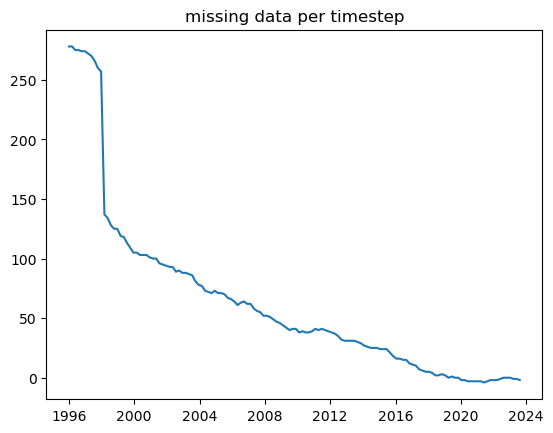

In [184]:
import matplotlib.pyplot as plt
plt.title('missing data per timestep')
plt.plot(500 - price_df.iloc[::50].count(axis=1))

### 2) dataset generated using fmp

In [8]:
import pickle
import os 
with open("fmp_key.pkl", "rb") as input_file:
  fmp_key = pickle.load(input_file)

with open("eod_key.pkl", "rb") as input_file:
  eod_key = pickle.load(input_file)

import urllib, json
import requests
from urllib.request import urlopen
import pandas as pd

# Function to get the Data

def get_jsonparsed_data(url):
    res = urlopen(url)
    data = res.read().decode("utf-8")
    return json.loads(data)

import datetime as dt
from tqdm import tqdm 

filename = 'price_df.csv'
data_provider  = 'eod' # other choice is 'fmp'

# first look up the historical s&p 500 constituents
constituents = get_jsonparsed_data("https://financialmodelingprep.com/api/v3/historical/sp500_constituent?apikey={}".format(fmp_key))
constituents = pd.DataFrame(constituents)
constituents['date'] = pd.to_datetime(constituents['date'])
all_tickers = set(constituents['symbol'].values)

begin = dt.datetime(1980,1,2)
end   = dt.datetime(2024,1,1)

price_df = pd.DataFrame(index=pd.date_range(start=begin, end=end, freq="B"))
failed_to_add = list()
# check if the file already exists
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)    

for count, ticker in enumerate(tqdm(all_tickers)):
    # find the correct dates the stock was part of the s&p 500
    date_begin = begin
    date_end   = end
    ticker = ticker.split(" ")[0]
    
    if ticker in price_df.columns:
        continue
    for _, row in constituents[constituents.symbol == ticker].iterrows():
        if len(row['addedSecurity']) != 0:
            date_begin = begin if row.date <= begin else row.date
        if len(row['removedSecurity']) != 0:
            date_end = end if row.date >= end else end

    if data_provider == 'fmp':
        # get the data from the fmp api
        df = get_jsonparsed_data("https://financialmodelingprep.com/api/v3/historical-price-full/{}?from={}&to={}&apikey={}".format(ticker,
            date_begin.strftime('%Y-%m-%d'),date_end.strftime('%Y-%m-%d'),fmp_key))
        if len(df) == 0:
            print('could not add {}'.format(ticker),end="")
            failed_to_add.append(ticker)
            continue
        df1 = pd.DataFrame(df['historical'])
        df1['date'] = pd.to_datetime(df1['date'])
        df1.set_index('date',inplace=True)
        # merge the dataset
        price_df = pd.merge(price_df, df1['adjClose'], how='left', left_index=True, right_index=True)
        price_df = price_df.rename(columns={'adjClose': ticker})
    elif data_provider == 'eod':
        df  = get_jsonparsed_data("https://eodhd.com/api/eod/{}.US?from={}&to={}&period=d&api_token={}&fmt=json".format(ticker,
            date_begin.strftime('%Y-%m-%d'),date_end.strftime('%Y-%m-%d'), eod_key))
        if len(df) == 0:
            print('could not add {}'.format(ticker),end="")
            failed_to_add.append(ticker)
            continue
        df1 = pd.DataFrame(df)
        df1['date'] = pd.to_datetime(df1['date'])
        df1.set_index('date',inplace=True)
        # merge the dataset
        price_df = pd.merge(price_df, df1['adjusted_close'], how='left', left_index=True, right_index=True)
        price_df = price_df.rename(columns={'adjusted_close': ticker})

    # occasionally backup the dataframe
    if count % 20 == 0:
        price_df.to_csv(filename)

KeyboardInterrupt: 